colab에서 사진과 파일을 관리하기 위해서 다음과 같이 drive를 mount하고 사진을 업로드합니다.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [47]:
!pip install dlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import dlib

In [9]:
!cp ./gdrive/MyDrive/face_cognitaion/자기소개서-사진.jpeg ./gdrive/MyDrive/face_cognitaion/20231220.jpeg ./gdrive/MyDrive/face_cognitaion/20240407.jpeg ./

!ls -al

total 1216
drwxr-xr-x 1 root root   4096 Apr  9 12:25 .
drwxr-xr-x 1 root root   4096 Apr  9 12:22 ..
-rw------- 1 root root 486603 Apr  9 12:25 20231220.jpeg
-rw------- 1 root root 577855 Apr  9 12:25 20240407.jpeg
drwxr-xr-x 4 root root   4096 Apr  5 13:20 .config
drwx------ 5 root root   4096 Apr  9 12:23 gdrive
-rw------- 1 root root 154556 Apr  9 12:25 자기소개서-사진.jpeg
drwxr-xr-x 1 root root   4096 Apr  5 13:21 sample_data


## 얼굴영역 binary mask 이미지 넣기  

주어진 이미지에서 얼굴을 감지하고, 해당 얼굴 영역을 피부색을 기반으로 분할하여 시각화하는 함수를 구현합니다.

함수는 다음의 과정을 거칩니다.
1. 이미지 로드: OpenCV를 사용하여 주어진 이미지를 로드합니다.
2. 얼굴 감지: OpenCV의 Haar Cascade 분류기를 사용하여 이미지에서 얼굴을 감지합니다.
3. 얼굴 영역 추출: 감지된 첫 번째 얼굴 영역을 추출하고, 해당 영역을 RGB 형식으로 변환합니다.
4. 피부색 마스크 생성: HSV(Hue, Saturation, Value) 색 공간으로 변환한 얼굴 영역에서 피부색을 나타내는 마스크를 생성합니다. 피부색은 주어진 skin_lower 값과 상한 값으로 지정됩니다.
5. 얼굴 영역 분할: 생성된 피부색 마스크를 사용하여 얼굴 영역을 분할하고, 이를 이진 마스크와 bitwise 연산을 수행하여 얼굴 영역을 추출합니다.
6. 결과 출력: 원본 이미지, 피부색 이진 마스크 및 분할된 얼굴 영역을 함께 시각화하여 출력합니다.

이때 다양한 사진에 대해서 코드를 재활용하기 위해서 함수로 작성했습니다.
이미지에 따라 밝기에 대한 정도가 달라 이미지 경로 외에도 skin_lower 값을 인자로 받습니다.

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_and_segment_face(image_path, skin_lower):
    # 이미지 로드
    bgr_img = cv2.imread(image_path)
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

    # 얼굴 감지기 초기화
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # 얼굴 감지
    faces = face_cascade.detectMultiScale(img_gray, scaleFactor=1.3, minNeighbors=5)

    # 얼굴이 감지되었을 때
    if len(faces) > 0:
        # 첫 번째 얼굴만 사용
        (x, y, w, h) = faces[0]

        # 얼굴 영역 추출 및 HSV 변환
        face_roi = rgb_img[y:y+h, x:x+w]
        hsv_face = cv2.cvtColor(face_roi, cv2.COLOR_RGB2HSV)

        # HSV 범위 지정 (피부색에 따라 조절 필요)
        lower_skin = np.array(skin_lower, dtype=np.uint8)
        upper_skin = np.array([30, 255, 255], dtype=np.uint8)

        # HSV 이미지에서 피부색 마스크 생성
        skin_mask = cv2.inRange(hsv_face, lower_skin, upper_skin)

        # 마스크를 사용하여 얼굴 영역 분할
        segmented_face = cv2.bitwise_and(face_roi, face_roi, mask=skin_mask)

        # 결과 출력
        plt.figure(figsize=(10,5))
        plt.subplot(1, 3, 1)
        plt.imshow(rgb_img)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(skin_mask, cmap='gray')
        plt.title('Binary Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(segmented_face)
        plt.title('Segmented Face')
        plt.axis('off')

        plt.show()

    else:
        print("No face detected.")


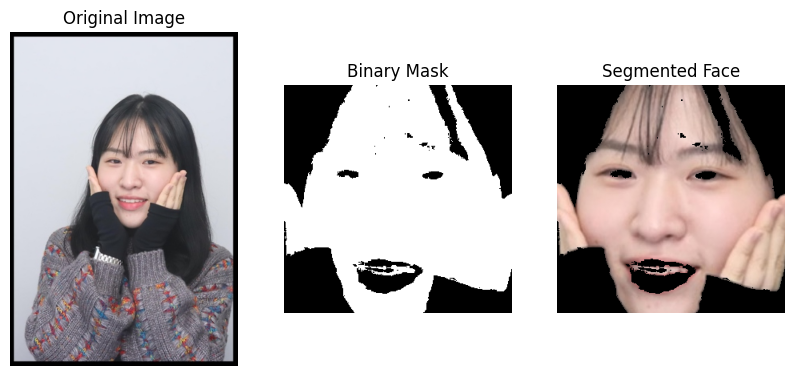

In [46]:
# 함수 호출하여 이미지에 대한 얼굴 감지 및 분할 수행
detect_and_segment_face('./자기소개서-사진.jpeg', [0, 37, 80])

위의 결과와 같이 얼굴을 감지하고 피부색에 대해서 마스킹 처리한 결과를 볼 수 있습니다. 다만 피부색과는 다른 입술색, 눈동자의 경우는 얼굴이 아닌 것으로 마스킹되는데 별도의 처리가 필요합니다.

## 얼굴을 감지하여 Bounding Box 그리기

이미지에서 얼굴을 감지하고, 감지된 얼굴 주변에 바운딩 박스를 그리기 위해서 다음의 과정을 거칩니다.

1. 얼굴 감지: OpenCV의 Haar Cascade 분류기를 사용하여 이미지에서 얼굴을 감지합니다. detectMultiScale 함수를 사용하여 얼굴을 검출하며, scaleFactor와 minNeighbors 매개변수는 각각 얼굴 크기에 대한 보정과 이웃사이의 최소 간격을 조절합니다.
2. 얼굴이 감지되었을 때: len(faces)를 사용하여 얼굴이 감지되었는지 여부를 확인합니다. 만약 얼굴이 한 개 이상 감지되었다면, 각 얼굴 주변에 바운딩 박스를 그려줍니다.
3. 원본 이미지에 바운딩 박스 그리기: cv2.rectangle 함수를 사용하여 원본 이미지에 각 얼굴 주변에 바운딩 박스를 그립니다. 이 때, 바운딩 박스의 색상은 (255, 0, 0)으로 지정되며, 두께는 2로 설정됩니다.
4. 결과 출력: 바운딩 박스가 그려진 이미지를 함께 시각화하여 출력합니다. 각 바운딩 박스의 좌표와 크기도 출력하여 사용자에게 얼굴이 감지된 위치에 대한 정보를 제공합니다.

이 코드를 실행하면 원본 이미지에 얼굴 주변에 바운딩 박스가 그려진 이미지가 출력됩니다.

Detected Bounding Boxes:
Face 1: (x=243, y=288), width=285, height=285


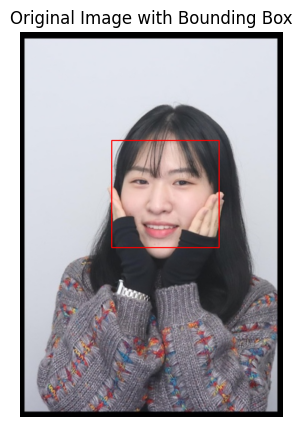

In [15]:

# 얼굴 감지
faces = face_cascade.detectMultiScale(img_gray, scaleFactor=1.3, minNeighbors=5)

# 얼굴이 감지되었을 때
if len(faces) > 0:
    # 원본 이미지에 bounding box 그리기
    for (x, y, w, h) in faces:
        cv2.rectangle(rgb_img, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # 결과 출력
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_img)
    plt.title('Original Image with Bounding Box')
    plt.axis('off')

    # 각 얼굴의 bounding box 좌표 출력
    print("Detected Bounding Boxes:")
    for i, (x, y, w, h) in enumerate(faces):
        print(f"Face {i+1}: (x={x}, y={y}), width={w}, height={h}")

    plt.show()
else:
    print("No face detected.")

## face detection과 face recognition을 수행하고 similarity 확인하기

위의 결과를 얻기 위해서 필요한 두가지 모델을 위한 파일을 다운받습니다.

각 파일은 dlib 라이브러리의 shape_predictor, face_recognition_model 모델을 위해서 쓰입니다.

- shape_predictor는 얼굴의 랜드마크(landmark)를 예측하기 위한 모델로 얼굴의 특정한 부분을 나타내는 점, 예를 들어 눈, 코, 입 등의 위치를 찾는 데 사용됩니다. 이러한 랜드마크를 예측하기 위해서는 사전에 학습된 얼굴 형태 모델이 필요한데 shape_predictor는 이를 위한 학습된 모델을 사용하여 얼굴 이미지에서 랜드마크를 찾아내고 반환합니다.

- face_recognition_model은 얼굴 인식과 관련된 모델로, 주어진 얼굴 이미지에서 얼굴의 특징 벡터(embedding)를 추출하는 역할을 합니다. 특징 벡터는 해당 얼굴의 고유한 특징을 잘 나타내는 숫자로 이루어져 있는데 face_recognition_model은 이러한 특징 벡터를 계산하기 위한 모델입니다.

즉, shape_predictor는 얼굴의 랜드마크를 예측하는 모델이고, face_recognition_model은 얼굴의 특징 벡터를 추출하는 모델입니다. 두 모델은 각각 얼굴의 형태와 특징을 추출하는 데 사용되며, 얼굴 감지 및 인식 시스템에서 함께 사용될 수 있습니다.

In [19]:
!wget https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2

# 다운로드한 파일을 압축 해제
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

!chmod 777 shape_predictor_68_face_landmarks.dat

face_landmarks_model = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

####
!wget http://dlib.net/files/dlib_face_recognition_resnet_model_v1.dat.bz2

!bzip2 -dk dlib_face_recognition_resnet_model_v1.dat.bz2

!chmod 777 dlib_face_recognition_resnet_model_v1.dat.bz2

!ls -al

--2024-04-09 12:27:52--  http://dlib.net/files/dlib_face_recognition_resnet_model_v1.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21428389 (20M)
Saving to: ‘dlib_face_recognition_resnet_model_v1.dat.bz2’

dlib_face_recogniti 100%[===================>]  20.44M  8.89MB/s    in 2.3s    

2024-04-09 12:27:54 (8.89 MB/s) - ‘dlib_face_recognition_resnet_model_v1.dat.bz2’ saved [21428389/21428389]

total 58600
drwxr-xr-x 1 root root     4096 Apr  9 12:27 .
drwxr-xr-x 1 root root     4096 Apr  9 12:22 ..
-rw------- 1 root root   486603 Apr  9 12:25 20231220.jpeg
-rw------- 1 root root   577855 Apr  9 12:25 20240407.jpeg
drwxr-xr-x 4 root root     4096 Apr  5 13:20 .config
-rw-r--r-- 1 root root 22466066 Feb 11  2017 dlib_face_recognition_resnet_model_v1.dat
-rwxrwxrwx 1 root root 21428389 Feb 11  2017 dlib_face_recognition_resnet_model_v1.dat.bz2
drwx------ 5 root 

[array([-0.11654575,  0.11337584,  0.06053355, -0.08851747, -0.13300417,
       -0.05938456, -0.07264607, -0.12715158,  0.13754386, -0.07868879,
        0.24234086, -0.05635488, -0.17185286, -0.06107996, -0.0602994 ,
        0.23265757, -0.17695436, -0.17329836, -0.04253821,  0.04062101,
        0.11422983, -0.00576218, -0.00977742,  0.06190396, -0.077521  ,
       -0.33816931, -0.0850479 , -0.04433892, -0.04416503, -0.06179601,
       -0.03071805,  0.00685545, -0.22970456, -0.04010081,  0.08100833,
        0.06244326,  0.01613634, -0.12423743,  0.1457046 , -0.03151503,
       -0.32055387,  0.07438898,  0.14930922,  0.15308541,  0.17525849,
        0.0348385 ,  0.01354956, -0.16729482,  0.16231611, -0.1458393 ,
        0.05093531,  0.13467245,  0.0646312 ,  0.04741169, -0.00667255,
       -0.19953413,  0.01563865,  0.14221235, -0.12581731, -0.01650226,
        0.09062354, -0.02720907, -0.02339314, -0.11225718,  0.1776671 ,
        0.12129508, -0.12371124, -0.23422803,  0.09996866, -0.1

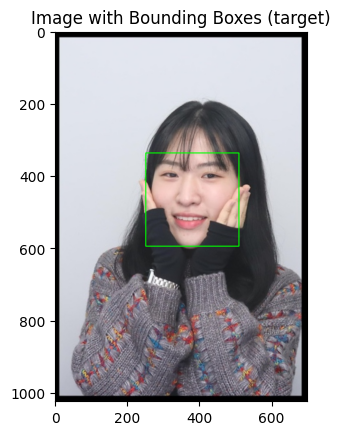

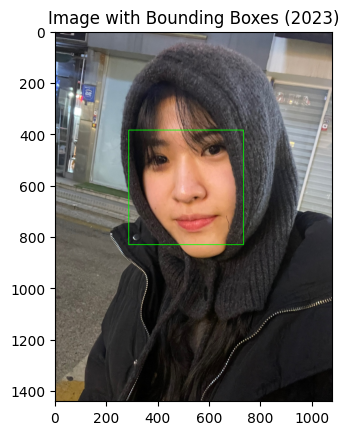

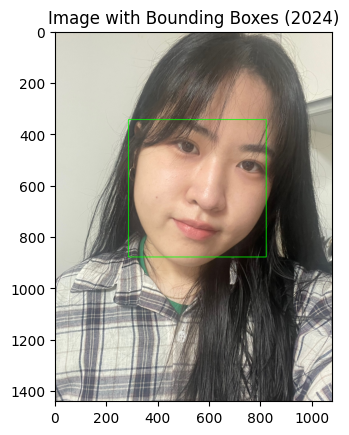

Similarities between faces in image 2023: 98.3409815210984
[98.3409815210984]
Similarities between faces in image 2024: 98.15489735372604
[98.15489735372604]


In [37]:
from sklearn.metrics.pairwise import cosine_similarity

def detect_faces(image):
    # 얼굴 감지기 초기화
    face_detector = dlib.get_frontal_face_detector()
    # 흑백 이미지로 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 얼굴 감지
    faces = face_detector(gray)
    return faces

def compute_embeddings(image, faces, shape_predictor):
    face_recognition_model = dlib.face_recognition_model_v1('./dlib_face_recognition_resnet_model_v1.dat')
    face_embeddings = []
    # 각 얼굴에 대해 embedding 계산
    for face in faces:
        # 얼굴 영역을 사각형 객체로 변환
        rect = dlib.rectangle(face.left(), face.top(), face.right(), face.bottom())
        # 얼굴에 대한 랜드마크 검출
        shape = shape_predictor(image, rect)
        # embedding 계산
        face_embedding = np.array(face_recognition_model.compute_face_descriptor(image, shape))
        face_embeddings.append(face_embedding)
    return face_embeddings

def calculate_similarity(embeddings, target_embedding):
    similarities = []
    # target_embedding을 NumPy 배열로 변환
    target_embedding = np.array(target_embedding)
    for embedding in embeddings:
        # 임베딩을 2차원 배열로 변환
        embedding = np.array(embedding).reshape(1, -1)
        target_embedding = target_embedding.reshape(1, -1)
        similarity = cosine_similarity(embedding, target_embedding)[0][0]
        similarity_percentage = (similarity + 1) / 2 * 100
        similarities.append(similarity_percentage)
    return similarities

def draw_bounding_boxes(image, faces):
    for face in faces:
        cv2.rectangle(image, (face.left(), face.top()), (face.right(), face.bottom()), (0, 255, 0), 2)
    return image

# 이미지 로드
bgr_img_2023 = cv2.imread('./20231220.jpeg')
bgr_img_2024 = cv2.imread('./20240407.jpeg')

# 얼굴 감지
faces_target = detect_faces(bgr_img)
faces_2023 = detect_faces(bgr_img_2023)
faces_2024 = detect_faces(bgr_img_2024)

# 얼굴 embedding 계산
shape_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
embeddings_target = compute_embeddings(bgr_img, faces_target, shape_predictor)
embeddings_2023 = compute_embeddings(bgr_img_2023, faces_2023, shape_predictor)
embeddings_2024 = compute_embeddings(bgr_img_2024, faces_2024, shape_predictor)
print(embeddings_target)
print(embeddings_2023)
print(embeddings_2024)

# 유사도 계산
similarities_2023 = calculate_similarity(embeddings_2023, embeddings_target)
similarities_2024 = calculate_similarity(embeddings_2024, embeddings_target)

# 바운딩 박스 그리기
image_with_boxes_target = draw_bounding_boxes(bgr_img.copy(), faces_target)
image_with_boxes_2023 = draw_bounding_boxes(bgr_img_2023.copy(), faces_2023)
image_with_boxes_2024 = draw_bounding_boxes(bgr_img_2024.copy(), faces_2024)

# 결과 시각화
plt.imshow(cv2.cvtColor(image_with_boxes_target, cv2.COLOR_BGR2RGB))
plt.title('Image with Bounding Boxes (target)')
plt.show()

plt.imshow(cv2.cvtColor(image_with_boxes_2023, cv2.COLOR_BGR2RGB))
plt.title('Image with Bounding Boxes (2023)')
plt.show()

plt.imshow(cv2.cvtColor(image_with_boxes_2024, cv2.COLOR_BGR2RGB))
plt.title('Image with Bounding Boxes (2024)')
plt.show()

print("Similarities between faces in image 2023: %s" % similarities_2023[0])
print(similarities_2023)

print("Similarities between faces in image 2024: %s" % similarities_2024[0])
print(similarities_2024)


### Face Detection 구현 및 얼굴 영역 분할
OpenCV를 사용하여 얼굴을 감지하고, HSV 컬러 세그멘테이션을 이용하여 얼굴 영역을 분할했습니다. 이를 통해 얼굴 영역을 이진 마스크 이미지로 표시했습니다.


### Bounding Box 및 얼굴 영역 그리기
OpenCV의 cv2.rectangle() 함수를 사용하여 감지된 얼굴에 바운딩 박스를 그리고 분할된 얼굴 영역을 원본 이미지에 덧씌웠습니다.


### Face Recognition 및 Embedding 비교
Dlib 라이브러리를 사용하여 Face Recognition을 수행하고, Embedding 값의 유사도를 비교했습니다. Embedding 값의 L2 norm 또는 normalized vector를 기준으로 Cosine Similarity를 계산하여 얼마나 비슷한 얼굴인지 확인했습니다.


### 다양한 Detector 및 Recognition 적용
Dlib detector와 직접 구현한 color segmentation mask 기반 detector를 비교하고, 두 방법의 결과 및 실행 속도를 비교하고자 하였으나 color 기반 detector가 자기소개서(target) 사진 외의 비교군 사진에 대해서 얼굴을 인지하지 못하는 문제가 발생하여 마무리하지 못했습니다.

다만 여기까지 진행한 결과로 알 수 있는 Dlib 기반 Face Detection 및 Recognition과 Color Segmentation Mask 기반 Face Detection 및 Recognition의 장단점은 다음과 같습니다.

#### Dlib 기반 Face Detection 및 Recognition
- 장점
  - 높은 정확도: Dlib은 높은 정확도로 얼굴을 감지하고, Face Recognition을 수행합니다.
  - 다양한 플랫폼 지원: 다양한 플랫폼에서 사용 가능합니다.
- 단점
  - 처리 속도: 큰 이미지나 다수의 얼굴을 처리할 때 처리 속도가 느립니다.
  - 학습 데이터 의존성: Face Recognition 모델의 성능은 학습된 데이터에 의존하므로, 적절한 학습 데이터가 없으면 정확도가 저하될 수 있습니다.

#### Color Segmentation Mask 기반 Detector:
- 장점
  - 빠른 처리 속도: 단순한 Color Segmentation을 사용하므로 처리 속도가 빠릅니다.
  - 학습 데이터 필요성 감소: Dlib과 달리 학습 데이터에 의존하지 않으므로, 적은 양의 데이터로도 감지가 가능합니다.
- 단점
  - 정확도 감소: Dlib에 비해 정확도가 낮을 수 있으며, 특히 다양한 조명 조건이나 각도에서 얼굴을 잘 감지하지 못합니다.
  - 환경 의존성: 세그멘테이션 방법은 조명, 배경 등의 환경 요소에 영향을 받을 수 있습니다. 실제로 사진에 맞는 피부값을 세부 설정해야 원하는 결과를 얻을 수 있었습니다.